# Clasificación de Hojas de Café

### Cargar las anotaciones del dataset

In [1]:
import json

annotations_file="RoCoLe.json"

with open(annotations_file,'r') as f:
    annotations=json.load(f)

### Dimensión del dataset

In [2]:
len(annotations)

1560

### Esquema de las anotaciones

In [3]:
annotations[2]

{'ID': 'cjvnf89dsfy900795gjew8qoj',
 'DataRow ID': 'cjvnehagg0jhz0ctnfqe98wpe',
 'Labeled Data': 'https://storage.googleapis.com/labelbox-193903.appspot.com/cjs5g735orqbe0b29ip8a1k1s%2F2b0c3fb0-23cf-d5ab-3e8f-b2ff6dad1120-C1P2H1.jpg',
 'Label': {'Leaf': [{'state': 'healthy',
    'geometry': [{'x': 15, 'y': 505},
     {'x': 114, 'y': 489},
     {'x': 390, 'y': 391},
     {'x': 516, 'y': 358},
     {'x': 705, 'y': 308},
     {'x': 886, 'y': 278},
     {'x': 1001, 'y': 280},
     {'x': 1150, 'y': 326},
     {'x': 1304, 'y': 379},
     {'x': 1383, 'y': 441},
     {'x': 1408, 'y': 482},
     {'x': 1481, 'y': 533},
     {'x': 1548, 'y': 521},
     {'x': 1484, 'y': 563},
     {'x': 1429, 'y': 606},
     {'x': 1422, 'y': 650},
     {'x': 1387, 'y': 684},
     {'x': 1281, 'y': 744},
     {'x': 1162, 'y': 795},
     {'x': 1107, 'y': 795},
     {'x': 1033, 'y': 813},
     {'x': 960, 'y': 804},
     {'x': 891, 'y': 813},
     {'x': 794, 'y': 808},
     {'x': 723, 'y': 774},
     {'x': 562, 'y': 74

### Crear una clase que contenga la información de las hojas

In [4]:
import cv2 as cv
import numpy as np

class CoffeeLeaf:    
    def __init__(self, leaf_id, state, classification, image_bgr, geometry):
        self.id = leaf_id
        self.state_manual = state
        self.state_computed = None
        self.classification_manual = classification
        self.classification_computed = None
        self.image_bgr = image_bgr
        self.image_rgb = None
        self.roi_rgb = None
        self.roi_gray = None
        self.roi_hsv = None
        self.mask = None
        self.polygon = None
        self.geometry = geometry
        self._generate_image_rgb()
        self._create_roi()
        self._create_mask()

    def _generate_image_rgb(self):
        self.image_rgb = cv.cvtColor(self.image_bgr, cv.COLOR_BGR2RGB)

    def _get_bounding_rect(self):
        polygon_points = [list(point.values()) for point in self.geometry]
        self.polygon = np.array(polygon_points)
        return cv.boundingRect(self.polygon)

    def _create_roi(self):
        x,y,w,h = self._get_bounding_rect()
        self.roi_rgb = self.image_rgb[y:y+h, x:x+w].copy()
        self.roi_gray = cv.cvtColor(self.roi_rgb, cv.COLOR_RGB2GRAY)
        self.roi_hsv = cv.cvtColor(self.roi_rgb, cv.COLOR_RGB2HSV)
    
    def _create_mask(self):
        polygon_start = self.polygon.min(axis=0)
        polygon_at_zero = self.polygon-polygon_start
        self.mask = np.zeros(self.roi_gray.shape, np.uint8)
        CONTOURS = -1 # All contours
        COLOR = (255, 255, 255) # White
        THICKNESS = -1 # Fill
        self.mask = cv.drawContours(self.mask, [polygon_at_zero], CONTOURS, COLOR, THICKNESS)

### Cargar las imágenes del dataset en objetos CoffeeLeaf

In [5]:
# REMOVER una vez que el proceso esté listo para aplicarse de manera general, es decir,
# trabajar temporalmente con una sola hoja, para reducir el tiempo de procesamiento

leaves_healthy = []
leaves_rust_level_1 = []
leaves_rust_level_2 = []
leaves_rust_level_3 = []
leaves_rust_level_4 = []
leaves_red_spider_mite = []

for annotation in annotations:
    classification = annotation["Label"]["classification"]
    if classification == "rust_level_1":
        leaves_rust_level_1.append(annotation)
    elif classification == "rust_level_2":
        leaves_rust_level_2.append(annotation)
    elif classification == "rust_level_3":
        leaves_rust_level_3.append(annotation)
    elif classification == "rust_level_4":
        leaves_rust_level_4.append(annotation)
    elif classification == "red_spider_mite":
        leaves_red_spider_mite.append(annotation)
    else:
        leaves_healthy.append(annotation)

annotations = leaves_healthy[0]

In [6]:
IMAGES_PATH = "../rocole_photos/"

coffee_leaves = []

for annotation in [annotations]:
    leaf_id = annotation["ID"]
    state = annotation["Label"]["Leaf"][0]["state"]
    geometry = annotation["Label"]["Leaf"][0]["geometry"]
    classification = annotation["Label"]["classification"]
    leaf_image = f"{IMAGES_PATH}/{leaf_id}.jpeg"
    image_bgr = cv.imread(leaf_image)
    coffee_leaf = CoffeeLeaf(leaf_id, state, classification, image_bgr, geometry)
    coffee_leaves.append(coffee_leaf)

In [7]:
coffee_leaf = coffee_leaves[0]

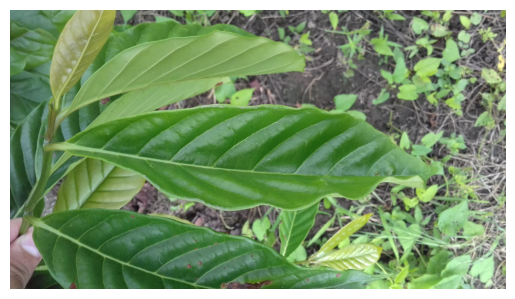

In [8]:
import matplotlib.pyplot as plt

plt.imshow(coffee_leaf.image_rgb)
plt.axis("off")
plt.show()

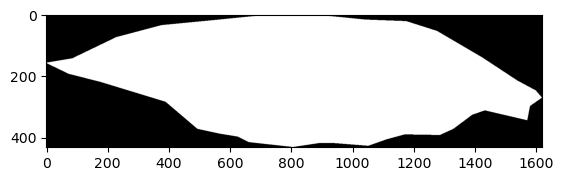

In [9]:
plt.imshow(coffee_leaf.mask, cmap='gray')
plt.show()

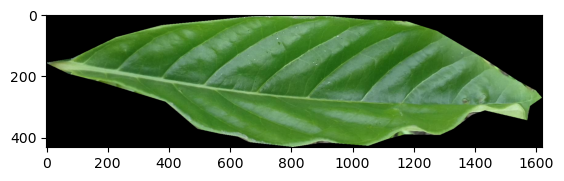

In [10]:
plt.imshow(cv.bitwise_and(coffee_leaf.roi_rgb, coffee_leaf.roi_rgb, mask=coffee_leaf.mask))
plt.show()

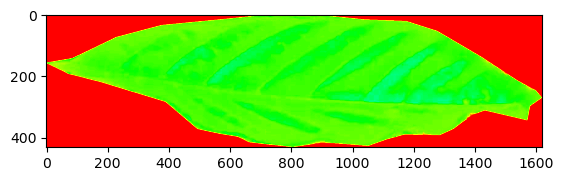

In [11]:
plt.imshow(cv.bitwise_and(coffee_leaf.roi_hsv[:,:,0], coffee_leaf.mask), cmap='hsv')
plt.show()

In [12]:
hist_h = cv.calcHist([coffee_leaf.roi_hsv], [0], coffee_leaf.mask, [256], [0,256])
hist_s = cv.calcHist([coffee_leaf.roi_hsv], [1], coffee_leaf.mask, [256], [0,256])
hist_v = cv.calcHist([coffee_leaf.roi_hsv], [2], coffee_leaf.mask, [256], [0,256])

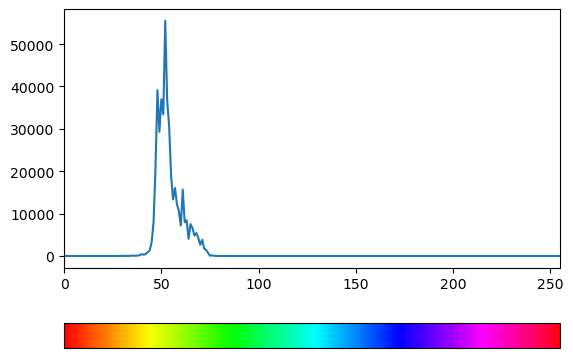

In [13]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=0, vmax=255)

fig, ax = plt.subplots()
plt.margins(x=0)
ax.plot(hist_h)
cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='hsv'), ax=ax, location='bottom')
cb.set_ticks([])
plt.show()